In [ ]:
from __future__ import print_function

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib import cm
import torchvision
import torchvision.datasets as datasets

# Set random seed for reproducibility
manualseed = 43
random.seed(manualseed)
torch.manual_seed(manualseed)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/cifar50.zip -d /content/gdrive/MyDrive/CIFAR50

Streaming output truncated to the last 5000 lines.
  inflating: /content/gdrive/MyDrive/CIFAR50/images/sunflower/train_23323.jpg  
  inflating: /content/gdrive/MyDrive/CIFAR50/images/sunflower/train_23431.jpg  
  inflating: /content/gdrive/MyDrive/CIFAR50/images/sunflower/train_23457.jpg  
  inflating: /content/gdrive/MyDrive/CIFAR50/images/sunflower/train_23464.jpg  
  inflating: /content/gdrive/MyDrive/CIFAR50/images/sunflower/train_23507.jpg  
  inflating: /content/gdrive/MyDrive/CIFAR50/images/sunflower/train_23533.jpg  
  inflating: /content/gdrive/MyDrive/CIFAR50/images/sunflower/train_23624.jpg  
  inflating: /content/gdrive/MyDrive/CIFAR50/images/sunflower/train_23707.jpg  
  inflating: /content/gdrive/MyDrive/CIFAR50/images/sunflower/train_23713.jpg  
  inflating: /content/gdrive/MyDrive/CIFAR50/images/sunflower/train_23801.jpg  
  inflating: /content/gdrive/MyDrive/CIFAR50/images/sunflower/train_23814.jpg  
  inflating: /content/gdrive/MyDrive/CIFAR50/images/sunflower/train_2

In [ ]:
!unzip /content/gdrive/MyDrive/cifar50_imbalance_0.02.zip -d /content/gdrive/MyDrive/CIFAR50_imbalance_0.02

Streaming output truncated to the last 5000 lines.
  inflating: /content/gdrive/MyDrive/CIFAR50_imbalance_0.02/images/flatfish/train_4763.jpg  
  inflating: /content/gdrive/MyDrive/CIFAR50_imbalance_0.02/images/flatfish/train_4764.jpg  
  inflating: /content/gdrive/MyDrive/CIFAR50_imbalance_0.02/images/flatfish/train_4765.jpg  
  inflating: /content/gdrive/MyDrive/CIFAR50_imbalance_0.02/images/flatfish/train_4766.jpg  
  inflating: /content/gdrive/MyDrive/CIFAR50_imbalance_0.02/images/flatfish/train_4767.jpg  
  inflating: /content/gdrive/MyDrive/CIFAR50_imbalance_0.02/images/flatfish/train_4768.jpg  
  inflating: /content/gdrive/MyDrive/CIFAR50_imbalance_0.02/images/flatfish/train_4769.jpg  
  inflating: /content/gdrive/MyDrive/CIFAR50_imbalance_0.02/images/flatfish/train_4770.jpg  
  inflating: /content/gdrive/MyDrive/CIFAR50_imbalance_0.02/images/flatfish/train_4771.jpg  
  inflating: /content/gdrive/MyDrive/CIFAR50_imbalance_0.02/images/flatfish/train_4772.jpg  
  inflating: /conte

Load and print label files to know the format of the provided labels.
- `cifar50_train.json`
- `cifar50_imbalance_0.02_train.json`

In [ ]:
# TODO: load json files and print.
import json
import os
import pandas as pd

os.chdir("/content/gdrive/MyDrive/CIFAR50")
f = open('cifar50_train.json','r')

data = json.loads(f.read())
df = pd.json_normalize(data['annotations'])
print(df)

                                              fpath  ...     category
0             data\cifar50\images\apple\train_0.jpg  ...        apple
1         data\cifar50\images\telephone\train_1.jpg  ...    telephone
2             data\cifar50\images\train\train_2.jpg  ...        train
3               data\cifar50\images\cup\train_3.jpg  ...          cup
4       data\cifar50\images\willow_tree\train_4.jpg  ...  willow_tree
...                                             ...  ...          ...
24995       data\cifar50\images\fox\train_24995.jpg  ...          fox
24996    data\cifar50\images\possum\train_24996.jpg  ...       possum
24997      data\cifar50\images\crab\train_24997.jpg  ...         crab
24998       data\cifar50\images\can\train_24998.jpg  ...          can
24999  data\cifar50\images\squirrel\train_24999.jpg  ...     squirrel

[25000 rows x 4 columns]


In [ ]:
os.chdir("/content/gdrive/MyDrive/CIFAR50_imbalance_0.02")

f = open('cifar50_imbalance_0.02_train.json','r')

data = json.load(f)
df_imbalance = pd.json_normalize(data['annotations'])
print(df_imbalance)

                                                  fpath  ...  category
0     data\cifar50_imbalance_0.02\images\apple\train...  ...     apple
1     data\cifar50_imbalance_0.02\images\apple\train...  ...     apple
2     data\cifar50_imbalance_0.02\images\apple\train...  ...     apple
3     data\cifar50_imbalance_0.02\images\apple\train...  ...     apple
4     data\cifar50_imbalance_0.02\images\apple\train...  ...     apple
...                                                 ...  ...       ...
6425  data\cifar50_imbalance_0.02\images\woman\train...  ...     woman
6426  data\cifar50_imbalance_0.02\images\woman\train...  ...     woman
6427  data\cifar50_imbalance_0.02\images\woman\train...  ...     woman
6428  data\cifar50_imbalance_0.02\images\woman\train...  ...     woman
6429  data\cifar50_imbalance_0.02\images\woman\train...  ...     woman

[6430 rows x 4 columns]


Show some images with labels (class names) from dataset.

In [ ]:
# Root directory for dataset
dataroot = "/content/gdrive/MyDrive/CIFAR50"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Learning rate for optimizers
lr = 0.0001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

In [ ]:
directory = "/content/gdrive/MyDrive/CIFAR50/images"

classes = [ f.name for f in os.scandir(directory) if f.is_dir() ]
print(classes)

['apple', 'baby', 'beaver', 'bee', 'bicycle', 'bowl', 'bridge', 'butterfly', 'can', 'caterpillar', 'chair', 'clock', 'cockroach', 'crab', 'cup', 'dolphin', 'flatfish', 'fox', 'hamster', 'kangaroo', 'lamp', 'leopard', 'lizard', 'man', 'motorcycle', 'mouse', 'oak_tree', 'orchid', 'palm_tree', 'pickup_truck', 'plain', 'poppy', 'possum', 'raccoon', 'road', 'rose', 'seal', 'shrew', 'skyscraper', 'snake', 'squirrel', 'sunflower', 'table', 'telephone', 'tiger', 'train', 'tulip', 'wardrobe', 'willow_tree', 'woman']


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
class CIFAR50(Dataset):
  def __init__(self, json_file,root_dir,transform=None,train=True):
    '''
        Reads json file, adds them to annotations. 
    '''
    with open (json_file, mode='r') as f:
      json_dump=f.read()
    json_fomatted=json.loads(json_dump)
    self.annotations= json_fomatted['annotations']
    self.root_dir=root_dir
    self.transform=transform

  def __len__(self):
    return (len(self.annotations))
  
  def __getitem__(self,index):
    '''
        Returns an image and label based on annotations
    '''
    img_path=os.path.join(self.annotations[index]['fpath'].replace('\\','/'))
    image_raw=cv2.imread(img_path)
    image=image_raw[:,:,::-1].copy()
    y_label=torch.tensor(int(self.annotations[index]['category_id']))
    if self.transform:
      image=self.transform(image)
    return (image,y_label)

In [ ]:
transform_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = CIFAR50("/content/gdrive/MyDrive/CIFAR50/cifar50_train.json", "/content/gdrive/MyDrive/CIFAR50/images", transform = transform_cifar, train = True)
test_dataset = CIFAR50("/content/gdrive/MyDrive/CIFAR50/cifar50_test.json", "/content/gdrive/MyDrive/CIFAR50/images", transform = transform_cifar, train = False)

print("Print the training dataset before augmentation:\n ", train_dataset)
print("Print the testing dataset:\n ", test_dataset)

Print the training dataset before augmentation:
Print the testing dataset:


In [ ]:
%cd '/content/gdrive/MyDrive'

/content/gdrive/MyDrive


In [ ]:
import json
json_dump=""
with open ("/content/gdrive/MyDrive/CIFAR50/cifar50_train.json", mode='r') as f:
    json_dump=f.read()
json_fomatted=json.loads(json_dump)
json_fomatted['annotations'][:5]

[{'category': 'apple',
  'category_id': 0,
  'fpath': 'data\\cifar50\\images\\apple\\train_0.jpg',
  'image_id': 0},
 {'category': 'telephone',
  'category_id': 86,
  'fpath': 'data\\cifar50\\images\\telephone\\train_1.jpg',
  'image_id': 1},
 {'category': 'train',
  'category_id': 90,
  'fpath': 'data\\cifar50\\images\\train\\train_2.jpg',
  'image_id': 2},
 {'category': 'cup',
  'category_id': 28,
  'fpath': 'data\\cifar50\\images\\cup\\train_3.jpg',
  'image_id': 3},
 {'category': 'willow_tree',
  'category_id': 96,
  'fpath': 'data\\cifar50\\images\\willow_tree\\train_4.jpg',
  'image_id': 4}]

data/cifar50/images/telephone/train_1.jpg
data/cifar50/images/train/train_2.jpg
data/cifar50/images/cup/train_3.jpg
data/cifar50/images/willow_tree/train_4.jpg
data/cifar50/images/sunflower/train_5.jpg


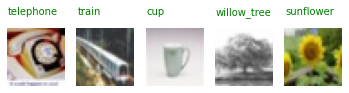

In [ ]:
import matplotlib.pyplot as plt
import cv2

json_fomatted['annotations'][0]
fig,ax=plt.subplots(1,5)
for i in range(1,6):
  img_path=json_fomatted['annotations'][i]['fpath'].replace('\\','/')
  print(img_path)
  img=cv2.imread("/content/gdrive/MyDrive/"+img_path)
  ax[i-1].imshow(img[:,:,::-1])
  ax[i-1].text(y=-8,x=0,s=json_fomatted['annotations'][i]['category'],color="g")
  ax[i-1].axis('off')
  fig.show()

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= 128, shuffle=True, sampler=None,
            batch_sampler=None, num_workers=0, collate_fn=None,
            pin_memory=False, drop_last=False, timeout=0,
            worker_init_fn=None, prefetch_factor=2,
            persistent_workers=False)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

print(train_loader)
print(test_loader)

In [ ]:
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '42')

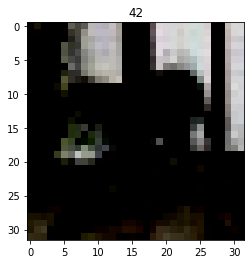

In [ ]:
iterator=iter(train_loader)
images, label=iterator.next()
plt.imshow(images[0].permute(1,2,0))
# plt.title(label_mapping[int(label[0])])
plt.title(int(label[0]))

In [ ]:
for X, y in train_loader:
  print("Shape of X [N, C, H, W]: ", X.shape)
  print("Shape of y: ", y.shape, y.dtype)
  break

Shape of X [N, C, H, W]:  torch.Size([128, 3, 32, 32])
Shape of y:  torch.Size([128]) torch.int64


## Train CNNs.

#### Use the CNN in HW2 to train the model on the balanced CIFAR50 dataset.

Train the CNN on the balanced CIFAR50 training set. Evaluate and report the classification accuracies on the testing set. 

Note: You can use any network configurations you implemented in HW2.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net().to(device)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(20):  
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss/2000))
            running_loss = 0.0
print('Finished Training')

Finished Training


In [ ]:
n_correct=0
n_samples=0
with torch.no_grad():
  for data in test_loader:
        inputs_test, labels_test = data
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        outputs_test = net(inputs_test)
        outputs_test = outputs_test.to(device)
        _, predicted = torch.max(outputs_test.data, 1)
        n_samples+=labels_test.size(0)
        n_correct+=(predicted==labels_test).sum().item() 
print('Test accuracy:', (n_correct/n_samples*100)) 

Test accuracy: 19.040000000000003


#### Use the same CNN in HW2 to train the model on the imbalanced CIFAR50 dataset.

Train the CNN on the imbalanced CIFAR50 training set. Evaluate and report the classification accuracies on the testing set. 


In [ ]:
# Root directory for dataset
dataroot = "/content/gdrive/MyDrive/data/cifar50_imbalance_0.02"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

In [ ]:
directory = "/content/gdrive/MyDrive/data/cifar50_imbalance_0.02/images"

classes = [ f.name for f in os.scandir(directory) if f.is_dir() ]
print(classes)

['apple', 'baby', 'beaver', 'bee', 'bicycle', 'bowl', 'bridge', 'butterfly', 'can', 'caterpillar', 'chair', 'clock', 'cockroach', 'crab', 'cup', 'dolphin', 'flatfish', 'fox', 'hamster', 'kangaroo', 'lamp', 'leopard', 'lizard', 'man', 'motorcycle', 'mouse', 'oak_tree', 'orchid', 'palm_tree', 'pickup_truck', 'plain', 'poppy', 'possum', 'raccoon', 'road', 'rose', 'seal', 'shrew', 'skyscraper', 'snake', 'squirrel', 'sunflower', 'table', 'telephone', 'tiger', 'train', 'tulip', 'wardrobe', 'willow_tree', 'woman']


In [ ]:
transform_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset_imbalanced = CIFAR50("/content/gdrive/MyDrive/data/cifar50_imbalance_0.02/cifar50_imbalance_0.02_train.json", "/content/gdrive/MyDrive/data/cifar50_imbalance_0.02/images", transform = transform_cifar, train = True)
test_dataset_imbalanced = CIFAR50("/content/gdrive/MyDrive/data/cifar50_imbalance_0.02/cifar50_imbalance_0.02_test.json", "/content/gdrive/MyDrive/data/cifar50_imbalance_0.02/images", transform = transform_cifar, train = False)

print("Print the training dataset before augmentation:\n ", train_dataset_imbalanced)
print("Print the testing dataset:\n ", test_dataset_imbalanced)

Print the training dataset before augmentation:
Print the testing dataset:


In [ ]:
import json
json_dump=""
with open ("/content/gdrive/MyDrive/data/cifar50_imbalance_0.02/cifar50_imbalance_0.02_train.json", mode='r') as f:
    json_dump=f.read()
json_fomatted=json.loads(json_dump)
json_fomatted['annotations'][:5]

[{'category': 'apple',
  'category_id': 0,
  'fpath': 'data\\cifar50_imbalance_0.02\\images\\apple\\train_0.jpg',
  'image_id': 0},
 {'category': 'apple',
  'category_id': 0,
  'fpath': 'data\\cifar50_imbalance_0.02\\images\\apple\\train_1.jpg',
  'image_id': 1},
 {'category': 'apple',
  'category_id': 0,
  'fpath': 'data\\cifar50_imbalance_0.02\\images\\apple\\train_2.jpg',
  'image_id': 2},
 {'category': 'apple',
  'category_id': 0,
  'fpath': 'data\\cifar50_imbalance_0.02\\images\\apple\\train_3.jpg',
  'image_id': 3},
 {'category': 'apple',
  'category_id': 0,
  'fpath': 'data\\cifar50_imbalance_0.02\\images\\apple\\train_4.jpg',
  'image_id': 4}]

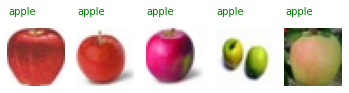

In [ ]:
import matplotlib.pyplot as plt
import cv2

json_fomatted['annotations'][0]
fig,ax=plt.subplots(1,5)
for i in range(1,6):
  img_path=json_fomatted['annotations'][i]['fpath'].replace('\\','/')
  img=cv2.imread("/content/gdrive/MyDrive/"+img_path)
  ax[i-1].imshow(img[:,:,::-1])
  ax[i-1].text(y=-8,x=0,s=json_fomatted['annotations'][i]['category'],color="Green")
  ax[i-1].axis('off')
  fig.show()

In [ ]:
train_loader_imbalanced = torch.utils.data.DataLoader(train_dataset_imbalanced, batch_size= 128, shuffle=True, sampler=None,
            batch_sampler=None, num_workers=0, collate_fn=None,
            pin_memory=False, drop_last=False, timeout=0,
            worker_init_fn=None, prefetch_factor=2,
            persistent_workers=False)

test_loader_imbalanced = torch.utils.data.DataLoader(test_dataset_imbalanced, batch_size= 128, shuffle=True, sampler=None,
            batch_sampler=None, num_workers=0, collate_fn=None,
            pin_memory=False, drop_last=False, timeout=0,
            worker_init_fn=None, prefetch_factor=2,
            persistent_workers=False)

print(train_loader_imbalanced)
print(test_loader_imbalanced)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '6')

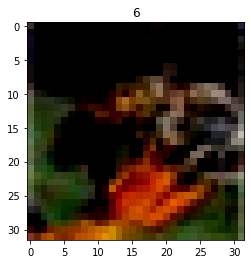

In [ ]:
iterator=iter(train_loader_imbalanced)
images, label=iterator.next()
plt.imshow(images[0].permute(1,2,0))
# plt.title(label_mapping[int(label[0])])
plt.title(int(label[0]))

In [ ]:
for X, y in train_loader_imbalanced:
  print("Shape of X [N, C, H, W]: ", X.shape)
  print("Shape of y: ", y.shape, y.dtype)
  break

Shape of X [N, C, H, W]:  torch.Size([128, 3, 32, 32])
Shape of y:  torch.Size([128]) torch.int64


In [ ]:
for epoch in range(20):  
    running_loss = 0.0
    for i, data in enumerate(train_loader_imbalanced, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss/2000))
            running_loss = 0.0
print('Finished Training')

Finished Training


In [ ]:
n_correct=0
n_samples=0
with torch.no_grad():
  for data in test_loader_imbalanced:
        inputs_test, labels_test = data
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        outputs_test = net(inputs_test)
        outputs_test = outputs_test.to(device)
        _, predicted = torch.max(outputs_test.data, 1)
        n_samples+=labels_test.size(0)
        n_correct+=(predicted==labels_test).sum().item() 
print('Test accuracy:', (n_correct/n_samples*100)) 

Test accuracy: 15.959999999999999


## Implement Tricks for LTR

Before starting this question, please read the paper for this homework: Bag of tricks for long-tailed visual recognition with deep convolutional neural networks.

According to this paper, select at least **three** tricks to implement on the imbalanced CIFAR50 training. 

In [ ]:
# TODO: trick 1 implementation
import glob
import pickle
class CIFAR_Dataset(Dataset):
    data_dir = "/content/gdrive/MyDrive/data/cifar50_imbalance_0.02"
    train = True
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    path = "/content/gdrive/MyDrive/data/cifar50_imbalance_0.02/images/*/train*.jpg"
    

    def __init__(self, data_dir = "/content/gdrive/MyDrive/data/cifar50_imbalance_0.02/", train = True, transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])):
        self.data_dir = data_dir
        self.train = train
        self.transform = transform
        self.data = []
        self.targets = []
        path = "/content/gdrive/MyDrive/data/cifar50_imbalance_0.02/images/*/train*.jpg"
        # Loading all the data depending on whether the dataset is training or testing
        if self.train:
          for filename in glob.glob(path):
            for i in range(len(classes)):
                #with open(data_dir + 'images/' + classes[i] + '/train_' + '.jpg' , 'rb') as f:
                with open(filename , 'rb') as f:
                    #entry = pickle.load(f, encoding='latin1')
                    
                    self.data.append(entry['data'])
                    self.targets.extend(entry['labels'])
        else:
            with open(data_dir + 'test_batch', 'rb') as f:
                entry = pickle.load(f, encoding='latin1')
                self.data.append(entry['data'])
                self.targets.extend(entry['labels'])

        # Reshape it and turn it into the HWC format which PyTorch takes in the images
        # Original CIFAR format can be seen via its official page
        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        # Create a one hot label
        label = torch.zeros(10)
        label[self.targets[idx]] = 1.

        # Transform the image by converting to tensor and normalizing it
        if self.transform:
            image = transform(self.data[idx])

        # If data is for training, perform mixup, only perform mixup roughly on 1 for every 5 images
        if self.train and idx > 0 and idx%5 == 0:

            # Choose another image/label randomly
            mixup_idx = random.randint(0, len(self.data)-1)
            mixup_label = torch.zeros(10)
            label[self.targets[mixup_idx]] = 1.
            if self.transform:
                mixup_image = transform(self.data[mixup_idx])

            # Select a random number from the given beta distribution
            # Mixup the images accordingly
            alpha = 0.2
            lam = np.random.beta(alpha, alpha)
            image = lam * image + (1 - lam) * mixup_image
            label = lam * label + (1 - lam) * mixup_label

        return image, label

In [ ]:
net = Net().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0002)
criterion = nn.CrossEntropyLoss()
best_Acc = 0

for epoch in range(20):
    net.train()
    # We train and visualize the loss every 100 iterations
    for idx, (imgs, labels) in enumerate(train_loader_imbalanced):
        imgs = imgs.to(device)
        labels = labels.to(device)
        preds = net(imgs)
        loss = criterion(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx%100 == 0:
            print("Epoch {} Iteration {}, Current Loss: {}".format(epoch, idx, loss))

    # We evaluate the network after every epoch based on test set accuracy
    net.eval()
    with torch.no_grad():
        total = 0
        numCorrect = 0
        for (imgs, labels) in test_loader_imbalanced:
            imgs = imgs.to(device)
            labels = labels.to(device)
            preds = net(imgs)
            numCorrect += (torch.argmax(preds, dim=-1) == torch.argmax(labels, dim=-1)).float().sum()
            total += len(imgs)
        acc = (numCorrect/total)*100
        print("Current image classification accuracy at epoch {}: {}".format(epoch, acc))
        if acc > best_Acc:
            best_Acc = acc

Epoch 0 Iteration 0, Current Loss: 4.614141464233398
Current image classification accuracy at epoch 0: 2.359999895095825
Epoch 1 Iteration 0, Current Loss: 3.7443413734436035
Current image classification accuracy at epoch 1: 1.9399998188018799
Epoch 2 Iteration 0, Current Loss: 3.255664110183716
Current image classification accuracy at epoch 2: 1.0
Epoch 3 Iteration 0, Current Loss: 3.4127871990203857
Current image classification accuracy at epoch 3: 2.1399998664855957
Epoch 4 Iteration 0, Current Loss: 3.291637420654297
Current image classification accuracy at epoch 4: 1.7799999713897705
Epoch 5 Iteration 0, Current Loss: 3.1298210620880127
Current image classification accuracy at epoch 5: 1.0
Epoch 6 Iteration 0, Current Loss: 2.975938081741333
Current image classification accuracy at epoch 6: 0.9599999785423279
Epoch 7 Iteration 0, Current Loss: 2.9351491928100586
Current image classification accuracy at epoch 7: 3.5999999046325684
Epoch 8 Iteration 0, Current Loss: 2.96202564239501

In [ ]:
# TODO: trick 2 implementation
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight

In [ ]:
net = Net().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0002)
criterion = nn.CrossEntropyLoss()
best_Acc = 0

for epoch in range(20):
    net.train()
    # We train and visualize the loss every 100 iterations
    for idx, (imgs, labels) in enumerate(train_loader_imbalanced):
        imgs = imgs.to(device)
        labels = labels.to(device)
        preds = net(imgs)
        loss = criterion(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx%100 == 0:
            print("Epoch {} Iteration {}, Current Loss: {}".format(epoch, idx, loss))

    # We evaluate the network after every epoch based on test set accuracy
    net.eval()
    with torch.no_grad():
        total = 0
        numCorrect = 0
        for (imgs, labels) in test_loader_imbalanced:
            imgs = imgs.to(device)
            labels = labels.to(device)
            preds = net(imgs)
            numCorrect += (torch.argmax(preds, dim=-1) == torch.argmax(labels, dim=-1)).float().sum()
            total += len(imgs)
        acc = (numCorrect/total)*100
        print("Current image classification accuracy at epoch {}: {}".format(epoch, acc))
        if acc > best_Acc:
            best_Acc = acc

In [ ]:
# TODO: trick 3 implementation
class_weight=[]

for root, subdir,files in os.walk(directory):
      if len(files)>0:
        class_weight.append(1/len(files))
class_weight = torch.FloatTensor(class_weight).to(device)

loss_fn = nn.CrossEntropyLoss(weight=class_weight)

In [ ]:
net = Net().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0002)
criterion = nn.CrossEntropyLoss()
best_Acc = 0

for epoch in range(20):
    net.train()
    # We train and visualize the loss every 100 iterations
    for idx, (imgs, labels) in enumerate(train_loader_imbalanced):
        imgs = imgs.to(device)
        labels = labels.to(device)
        preds = net(imgs)
        loss = criterion(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx%100 == 0:
            print("Epoch {} Iteration {}, Current Loss: {}".format(epoch, idx, loss))

    # We evaluate the network after every epoch based on test set accuracy
    net.eval()
    with torch.no_grad():
        total = 0
        numCorrect = 0
        for (imgs, labels) in test_loader_imbalanced:
            imgs = imgs.to(device)
            labels = labels.to(device)
            preds = net(imgs)
            numCorrect += (torch.argmax(preds, dim=-1) == torch.argmax(labels, dim=-1)).float().sum()
            total += len(imgs)
        acc = (numCorrect/total)*100
        print("Current image classification accuracy at epoch {}: {}".format(epoch, acc))
        if acc > best_Acc:
            best_Acc = acc

Evaluate and report the classification performance on CIFAR50 testing set.